## **Intelligent Quality Control and Predictive Maintenance System**
### **Introduction**
In the manufacturing industry, quality control and predictive maintenance are crucial for ensuring product reliability and operational efficiency. This project leverages machine learning and deep learning techniques to address two critical aspects of manufacturing: defect detection and predictive maintenance. By utilizing the MVTec AD dataset for anomaly detection and the SECOM dataset for predictive maintenance, we aim to develop robust models that can identify defects in products and predict potential equipment failures.

### **Objective**

The primary objectives of this project are:

1_ Defect Detection Using Convolutional Neural Networks (CNNs): To build a CNN model that can accurately detect various types of defects in products using the MVTec Anomaly Detection (AD) dataset. This includes preprocessing images, augmenting data, and training a CNN model to classify defects.

2_ Predictive Maintenance Using Random Forests: To develop a predictive maintenance model using the SECOM manufacturing dataset. This involves preprocessing sensor data, handling missing values, and training a Random Forest model to predict equipment failures.



### **Dataset Selection and Descriptio**n
MVTec Anomaly Detection (AD) Dataset

*   Description: The MVTec AD dataset consists of high-resolution images for anomaly detection tasks. It includes various defect types across different object categories.
*   Application: This dataset is used for training and testing the defect detection model.




### **SECOM Manufacturing Dataset**


*   Description: The SECOM dataset includes sensor data collected from a semiconductor manufacturing process. It contains features related to the production process and a target variable indicating pass/fail status.
*   Application: This dataset is used for developing the predictive maintenance model.



### **Model Selection **
#### Defect Detection



*   **Model:** Convolutional Neural Network (CNN)
*   **Justification:** CNNs are effective for image classification tasks due to their ability to capture spatial hierarchies in images. They are well-suited for detecting defects in high-resolution images.


*   **Loss Function**: Categorical Crossentropy is used because it is appropriate for multi-class classification tasks.
*   List item

### **Predictive Maintenance**


*   **Model:** Random Forest Classifier
*   **Justification:** Random Forests are robust and can handle the variability in sensor data. They are also effective in handling missing values and providing feature importance.


*   **Loss Function:** Not applicable for Random Forest as it is a non-parametric method.

















#### Import Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


#### Download and Prepare Datasets

In [ ]:
# Configure Kaggle API and download datasets
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ipythonx/mvtec-ad
!kaggle datasets download -d paresh2047/uci-semcom
!unzip /content/mvtec-ad.zip -d /content/mvtec_anomaly_detection
!unzip /content/uci-semcom.zip -d /content/secom_data


Streaming output truncated to the last 5000 lines.
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/151.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/152.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/153.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/154.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/155.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/156.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/157.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/158.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/159.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/160.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/161.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/good/162.png  
  inflating: /content/mvtec_anomaly_detection/carpet/train/go

#### Preprocess MVTec AD Dataset

In [ ]:
def load_and_preprocess_images(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    categories = os.listdir(data_dir)
    for category in categories:
        if category in ['ground_truth', 'license.txt', 'readme.txt']:
            continue
        category_path = os.path.join(data_dir, category)
        for split in ['train', 'test']:
            split_path = os.path.join(category_path, split)
            defect_types = os.listdir(split_path)
            for defect_type in defect_types:
                defect_type_path = os.path.join(split_path, defect_type)
                for img_file in os.listdir(defect_type_path):
                    img_path = os.path.join(defect_type_path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    if img is None:
                        continue
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(f"{category}_{defect_type}")
    return np.array(images), np.array(labels)

# Load and preprocess images
mvtec_data_dir = '/content/mvtec_anomaly_detection'
images, labels = load_and_preprocess_images(mvtec_data_dir)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded, num_classes=len(np.unique(labels_encoded)))
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

#### Exploratory Data Analysis (EDA) on MVTec AD Dataset

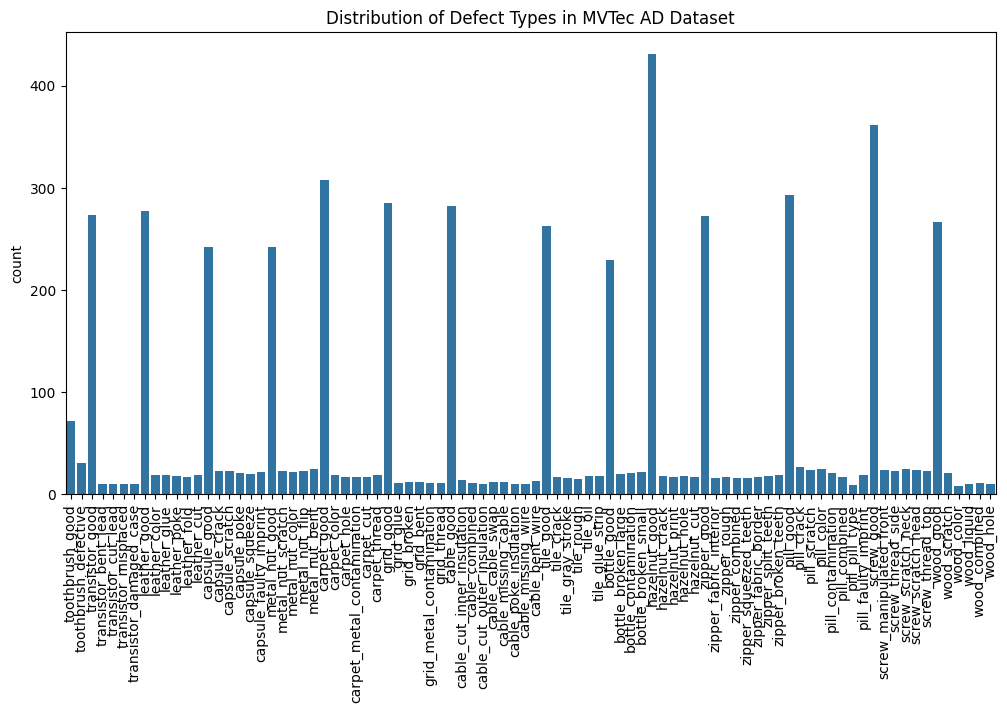

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x=label_encoder.inverse_transform(labels_encoded.argmax(axis=1)))
plt.xticks(rotation=90)
plt.title("Distribution of Defect Types in MVTec AD Dataset")
plt.show()




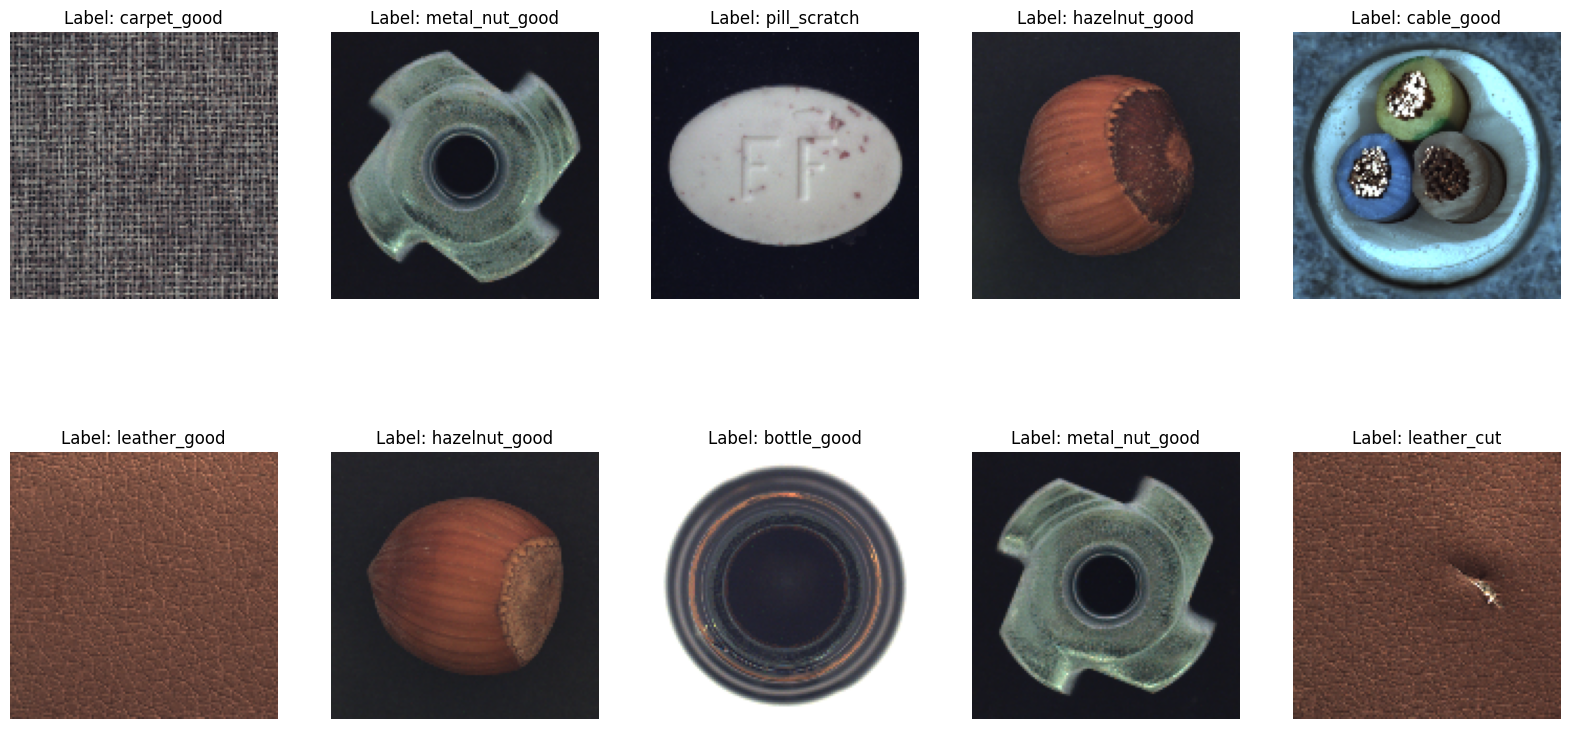

In [ ]:
def display_sample_images(images, labels, label_encoder, num_samples=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = label_encoder.inverse_transform([np.argmax(labels[idx])])[0]
        plt.subplot(2, num_samples//2, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

display_sample_images(X_train, y_train, label_encoder)

#### Preprocess SECOM Manufacturing Data

In [ ]:
secom_data_file = '/content/secom_data/uci-secom.csv'
data = pd.read_csv(secom_data_file)
data = data.drop(columns=['Time'])
features = data.drop(columns=['Pass/Fail'])
target = data['Pass/Fail']
features = features.replace('?', np.nan)
features = features.dropna(axis=1, thresh=int(0.9 * len(features)))
features = features.fillna(features.mean())
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
joblib.dump(scaler, 'scaler.pkl')
X_train_secom, X_test_secom, y_train_secom, y_test_secom = train_test_split(features_scaled, target, test_size=0.2, random_state=42)


#### Exploratory Data Analysis (EDA) on SECOM Data

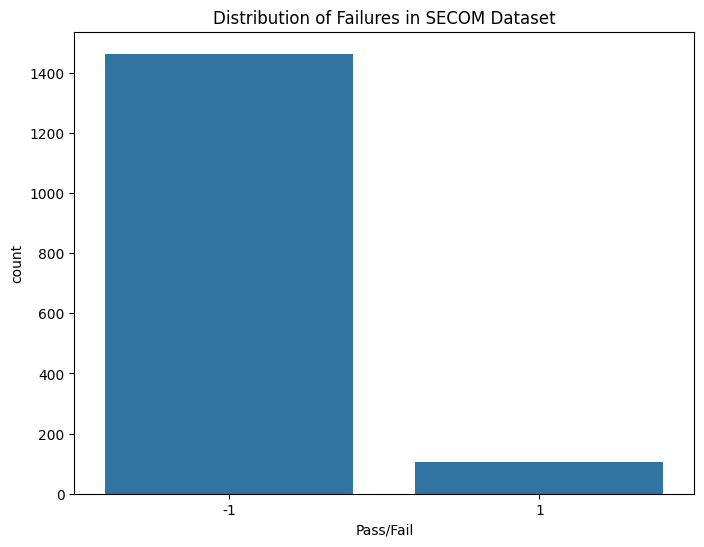

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target)
plt.title("Distribution of Failures in SECOM Dataset")
plt.show()




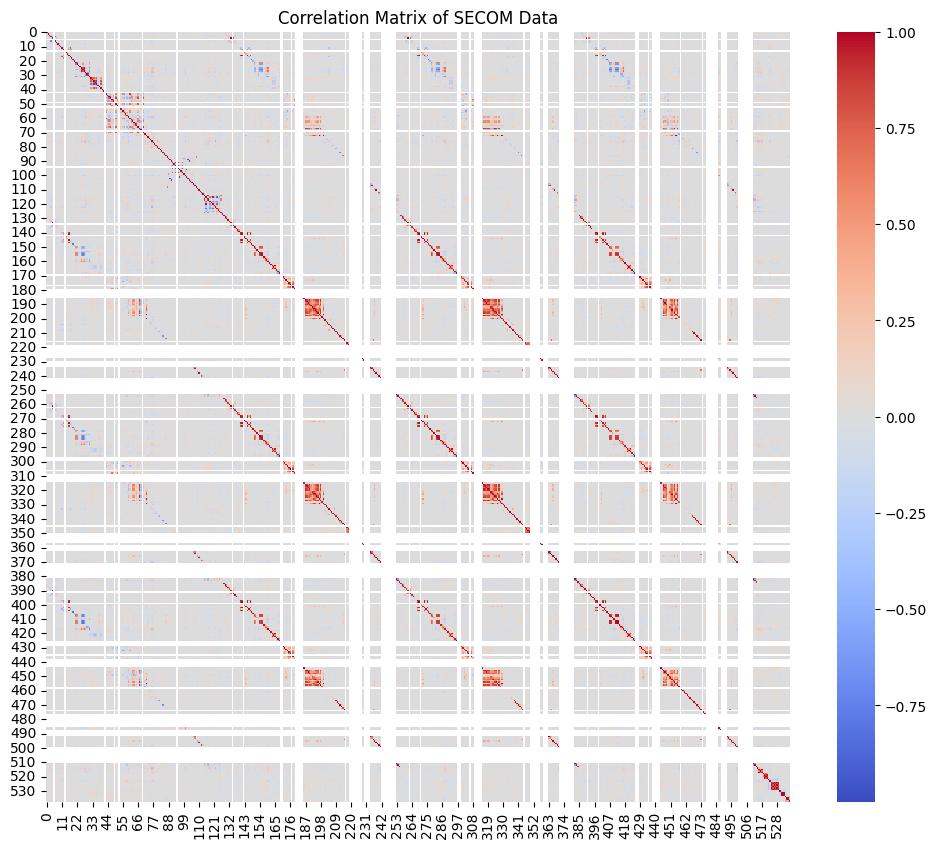

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = pd.DataFrame(features_scaled).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of SECOM Data")
plt.show()

#### Train Models - CNN for Defect Detection

In [ ]:
num_classes = len(np.unique(labels_encoded.argmax(axis=1)))
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
cnn_model = build_cnn_model(input_shape, num_classes)
history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])
cnn_model.save('defect_detection_model.h5')


Epoch 1/50
134/134 [==============================] - ETA: 0s - loss: 6.3107 - accuracy: 0.4193

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


134/134 [==============================] - 174s 1s/step - loss: 6.3107 - accuracy: 0.4193 - val_loss: 2.2726 - val_accuracy: 0.4799
Epoch 2/50
134/134 [==============================] - 166s 1s/step - loss: 2.0746 - accuracy: 0.5349 - val_loss: 1.8010 - val_accuracy: 0.5378
Epoch 3/50
134/134 [==============================] - 167s 1s/step - loss: 1.7370 - accuracy: 0.5648 - val_loss: 1.6222 - val_accuracy: 0.5864
Epoch 4/50
134/134 [==============================] - 172s 1s/step - loss: 1.6372 - accuracy: 0.5811 - val_loss: 1.5367 - val_accuracy: 0.5948
Epoch 5/50
134/134 [==============================] - 175s 1s/step - loss: 1.5378 - accuracy: 0.6136 - val_loss: 1.5545 - val_accuracy: 0.6088
Epoch 6/50
134/134 [==============================] - 170s 1s/step - loss: 1.4474 - accuracy: 0.6302 - val_loss: 1.3849 - val_accuracy: 0.6050
Epoch 7/50
134/134 [==============================] - 172s 1s/step - loss: 1.4604 - accuracy: 0.6404 - val_loss: 1.3523 - val_accuracy: 0.7059
Epoch 8/50

#### Plotting Training and Validation Accuracy/Loss

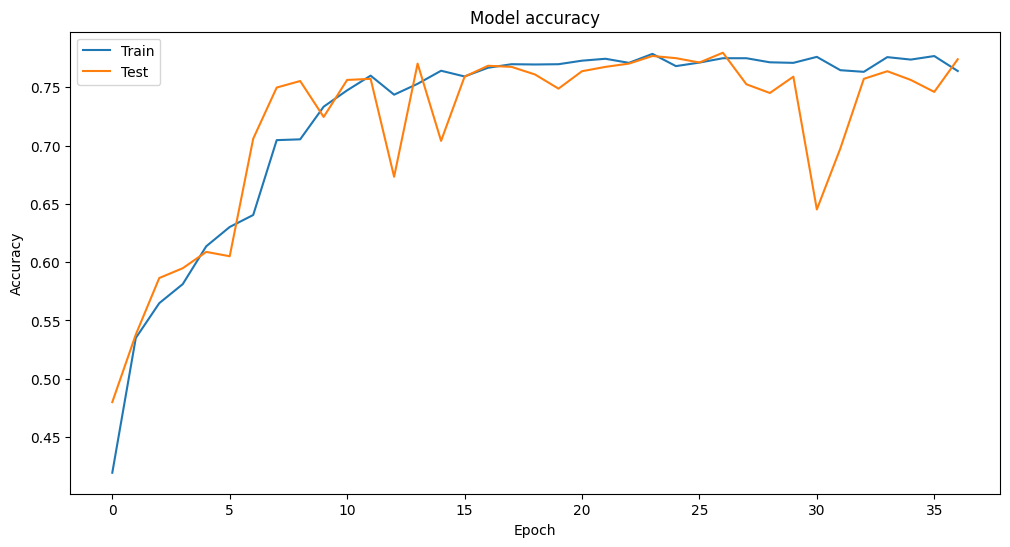

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



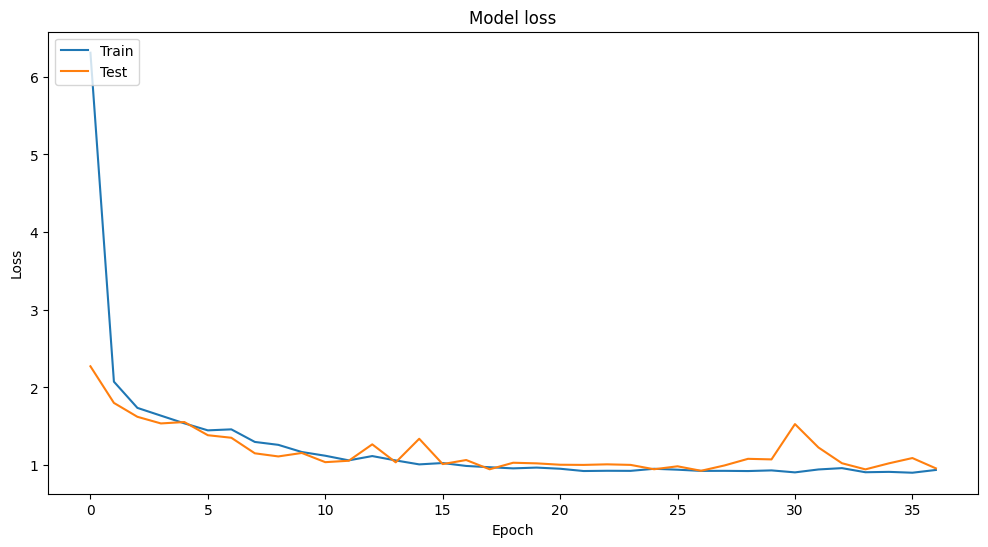

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Train Models - Random Forest for Predictive Maintenance

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_secom, y_train_secom)
best_rf_model = grid_search.best_estimator_
joblib.dump(best_rf_model, 'predictive_maintenance_model.pkl')


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


['predictive_maintenance_model.pkl']

#### Evaluation of Models

###### 1- Evaluate the CNN Model

In [ ]:
best_cnn_model = load_model('best_cnn_model.h5')
loss, accuracy = best_cnn_model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')


34/34 [==============================] - 8s 239ms/step - loss: 0.9269 - accuracy: 0.7796
Test accuracy: 77.96%


###### 2-Evaluate Random Forest Model

In [ ]:
y_pred_secom = best_rf_model.predict(X_test_secom)
print(f'Test accuracy: {accuracy_score(y_test_secom, y_pred_secom) * 100:.2f}%')
print(classification_report(y_test_secom, y_pred_secom))


Test accuracy: 92.36%
              precision    recall  f1-score   support

          -1       0.92      1.00      0.96       290
           1       0.00      0.00      0.00        24

    accuracy                           0.92       314
   macro avg       0.46      0.50      0.48       314
weighted avg       0.85      0.92      0.89       314



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###### 3- Confusion Matrix

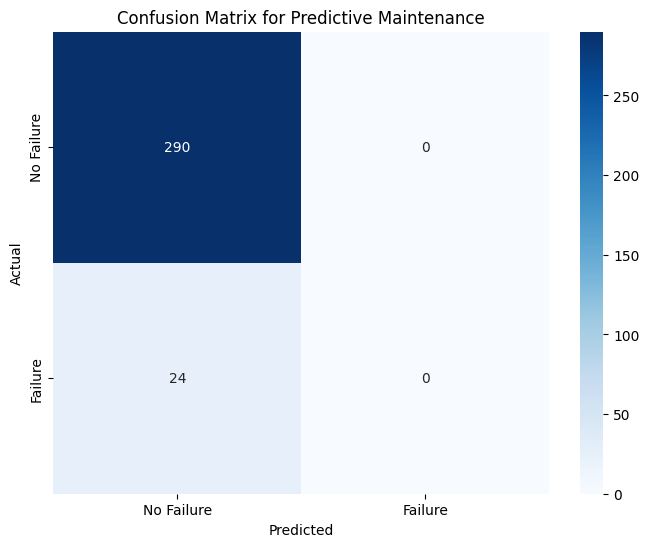

In [ ]:
conf_matrix = confusion_matrix(y_test_secom, y_pred_secom)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Failure', 'Failure'], yticklabels=['No Failure', 'Failure'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Predictive Maintenance')
plt.show()


###### Visualizing Predictions for CNN Model

34/34 [==============================] - 11s 312ms/step


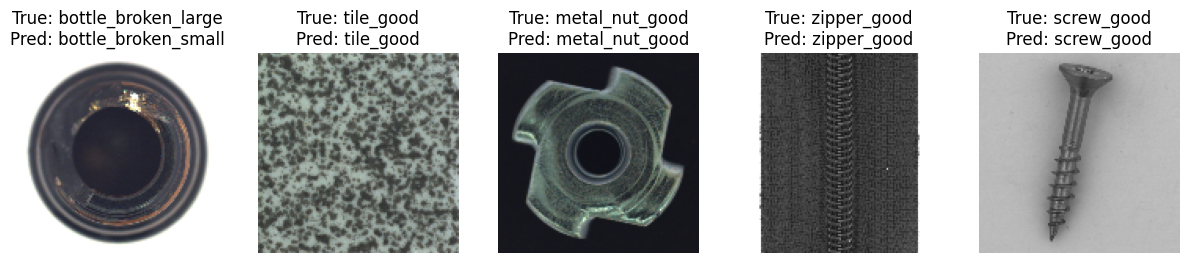

In [ ]:
def plot_predictions(images, true_labels, pred_labels, encoder, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        true_label = encoder.inverse_transform([np.argmax(true_labels[idx])])[0]
        pred_label = encoder.inverse_transform([np.argmax(pred_labels[idx])])[0]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

predictions = best_cnn_model.predict(X_test)
plot_predictions(X_test, y_test, predictions, label_encoder)


#### Simulate Real-Time Predictive Maintenance

In [ ]:
best_rf_model = joblib.load('predictive_maintenance_model.pkl')
scaler = joblib.load('scaler.pkl')
print(f"Number of features used to fit scaler: {scaler.n_features_in_}")
feature_names = scaler.feature_names_in_

def get_real_time_sensor_data():
    num_features = scaler.n_features_in_
    data = np.random.rand(1, num_features)
    data_df = pd.DataFrame(data, columns=feature_names)
    return data_df

start_time = time.time()
run_duration = 120

while time.time() - start_time < run_duration:
    sensor_data = get_real_time_sensor_data()
    if not all(sensor_data.columns == feature_names):
        raise ValueError("Feature names do not match those used during fit.")
    sensor_data_scaled = scaler.transform(sensor_data)
    prediction = best_rf_model.predict(sensor_data_scaled)
    if prediction[0] == 1:
        print("Maintenance required")
    time.sleep(5)

print("Completed fixed duration of monitoring.")


Number of features used to fit scaler: 538
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Maintenance required
Completed fixed duration of monitoring.
